In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [11]:
from scipy.interpolate import interp1d
from scipy.special import gamma
import numpy as np
from numpy.ma import masked_array
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad
import matplotlib.patches as patches
from itertools import product
from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
from py_unsio import *
import os
import glob
import wkbl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from astropy.io import fits
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
from matplotlib.colors import LogNorm
import iminuit
from iminuit import Minuit, describe, Struct
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from StringIO import StringIO
import datetime
import scipy.ndimage as ndimage
from astropy import units as u
from astropy import cosmology
from astropy.cosmology import WMAP5, Planck15
MetalFlag=0

In [3]:



path  = "/data/OWN/SF1test/SF0/mstar1_T3600/output_00041"
print path
###old ramses
myhalo = wkbl.Galaxy_Hound(path)
print "boxsize = {1} kpc".format(myhalo.dm.pos3d[:,1].min(),myhalo.dm.pos3d[:,1].max())
# zoom region
zoom_reg = np.where(myhalo.dm.mass==myhalo.dm.mass.min())
# iterative COM of dm in Zoom region
nucenter = nbe.real_center(myhalo.dm.pos3d[zoom_reg],myhalo.dm.mass[zoom_reg])
# recenter
myhalo.center_shift(nucenter)
# compute r_virial and cuts inside n=2
myhalo.r_virial(600,n=6)


myhalo.redefine(7)


/data/OWN/SF1test/SF0/mstar1_T3600/output_00041
loading Dark matter..
loading Stars..
loading Gas..
boxsize = 36844.5859375 kpc


/home/arturo/Documents/git/WKBL/wkbl/astro/galaxy_peeker.py:78: RuntimeWarning: divide by zero encountered in divide
  rho_s = np.cumsum(mhist) / vol_bin
/home/arturo/Documents/git/WKBL/wkbl/astro/_dark_matter.py:68: RuntimeWarning: invalid value encountered in arccos
  self.theta = np.arccos(np.copy(self.pos3d[:,0]),np.copy(self.r))
/home/arturo/Documents/git/WKBL/wkbl/astro/_stars.py:59: RuntimeWarning: invalid value encountered in arccos
  self.theta = np.arccos(np.copy(self.pos3d[:,0]),np.copy(self.r))


| r_200 = 212.70
| Diagonal matrix computed 
|    | 20, 0, 0|
| D =| 0, 14, 0|
|    | 0,  0, 4|


In [4]:
print "r200 = {0} kpc".format(myhalo.r200)
print "M200 = {0} Msun".format(myhalo.dm.total_m)

"""
## new Ramses
myhalo = wkbl.Galaxy_Hound(path,virial=True)
myhalo.r_virial(600)
"""
ok,myhalo.st.rho,_= CF.getDensity(np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),
                                           dtype=np.float32), myhalo.st.mass)


MagMet=MagAge=MagU=MagB=MagV=MagR=MagI=MagJ=MagH=MagK=np.array([0])

with open('luminosityFiles/NoObscuration.txt') as maginfo:
        for line in maginfo:
             #print(line)

             result=np.genfromtxt(StringIO(line),comments='#',delimiter=None)
             #magage=np.append(magage,result[0])
             #print result
             if len(result)>0:
                 MagMet=np.append(MagMet,result[0])
                 MagAge=np.append(MagAge,result[1])
                 MagU=np.append(MagU,result[3])
                 MagB=np.append(MagB,result[4])
                 MagV=np.append(MagV,result[5])
                 MagR=np.append(MagR,result[6])
                 MagI=np.append(MagI,result[7])
                 MagJ=np.append(MagJ,result[8])
                 MagH=np.append(MagH,result[9])
                 MagK=np.append(MagK,result[10])
MagMet=MagMet[1:]
MagAge=-MagAge[1:]/1e9
MagU=MagU[1:]
MagB=MagB[1:]
MagV=MagV[1:]
MagR=MagR[1:]
MagI=MagI[1:]
MagJ=MagJ[1:]
MagH=MagH[1:]
MagK=MagK[1:]

def MagCalc(Mag_band,SolMagBand):
    def the_func(metal,age,mass):
        #Select first 2 matrices by metal...
        selection = np.where(abs(metal-MagMet)<=abs(metal-MagMet).min())
        MagAgeSelected=MagAge[selection]
        MagSelected=Mag_band[selection]
        #...then search for the closest star age in the selected list
        ind=np.argmin(abs(age-MagAgeSelected))
        #Calculate Bolometric Magnitude
        mag=MagSelected[ind]-2.5*np.log10(mass)
        #Calculate
        lum=10**((SolMagBand-mag)/2.5)  #in Solar Luminosities
        return mag,lum
    calculate = np.vectorize(the_func)
    return calculate(myhalo.st.metal, myhalo.st.age, myhalo.st.mass)



r200 = 212.6953125 kpc
M200 = 8.21493497856e+11 Msun


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: UserWarning: genfromtxt: Empty input file: "<StringIO.StringIO instance at 0x7f4233514c68>"
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: UserWarning: genfromtxt: Empty input file: "<StringIO.StringIO instance at 0x7f42335144d0>"


In [5]:

magUSun = 5.55
magBSun = 5.45
magVSun = 4.80
magRSun = 4.46
magISun = 4.11
magJSun = 3.67
magHSun = 3.33
magKSun = 3.29


a = datetime.datetime.now()
mag_R,lum_R = MagCalc(MagR,magRSun)
b = datetime.datetime.now()
print "making magnitude in R took {0}".format(b-a)


a = datetime.datetime.now()
mag_U,lum_U = MagCalc(MagU,magUSun)
b = datetime.datetime.now()
print "making magnitude in U took {0}".format(b-a)

a = datetime.datetime.now()
mag_B,lum_B = MagCalc(MagB,magBSun)
b = datetime.datetime.now()
print "making magnitude in B took {0}".format(b-a)

print "###################### 200 kpc #############################"

text_fileR = open("../../face_R_02Mpc.txt", "w")
text_fileU = open("../../face_U_02Mpc.txt", "w")
text_fileB = open("../../face_B_02Mpc.txt", "w")
thismagR = mag_R
thismagU = mag_U
thismagB = mag_B

cut = (myhalo.st.r<30)&(np.abs(myhalo.st.pos3d[:,2])<2)
pos = (myhalo.st.pos3d[cut])

the1, the2 = 0,0
c1,s1 = np.cos(np.deg2rad(the1)),np.sin(np.deg2rad(the1))
c2,s2 = np.cos(np.deg2rad(the2)),np.sin(np.deg2rad(the2))
pos2 = np.copy(pos)
pos2[:,0] =  pos[:,0]*c1 - pos[:,1]*s1*c2 - pos[:,2]*s1*s2
pos2[:,1] = -pos[:,0]*s1 + pos[:,1]*c1*c2 - pos[:,2]*s2*c1
pos2[:,2] =  pos[:,1]*s2 + pos[:,2]*c2
pos = pos2
# calculates the ab magnitude of stars ar z = 0.00005 -> 200 kpc
Dl = Planck15.luminosity_distance(0.0000312)
print Dl
# here we define the distance of each star to the observer
d = (pos[:,2]*1e3)+Dl.value * 1e6 # in parsecs

# Changin to pixel coords and centering the the galaxy in a picture of n_pixels
n_pixels, frame_size = 1024 , 40 # pixel, kpc
pos = (pos*n_pixels/frame_size) + [n_pixels/2.,n_pixels/2.,n_pixels/2.]
####################



making magnitude in R took 0:00:21.808959
making magnitude in U took 0:00:17.463835
making magnitude in B took 0:00:24.772958
###################### 200 kpc #############################
0.138083095392 Mpc


In [6]:
###### magR
f_d10 = 10**(-thismagR[cut]/2.5)
f_d = f_d10*(10./d)**2
m_ab_R = -2.5* np.log10(f_d/3631)+7-0.8
print "R band ->",m_ab_R.min(),m_ab_R.mean(),m_ab_R.max()

###### magU
f_d10 = 10**(-thismagU[cut]/2.5)
f_d = f_d10*(10./d)**2
m_ab_U = -2.5* np.log10(f_d/3631)+5-0.5
print "U band ->",m_ab_U.min(),m_ab_U.mean(),m_ab_U.max()

###### magB
f_d10 = 10**(-thismagB[cut]/2.5)
f_d = f_d10*(10./d)**2
m_ab_B = -2.5* np.log10(f_d/3631)+6-1.2
print "B band ->",m_ab_B.min(),m_ab_B.mean(),m_ab_B.max()
toppoint, zeropoint = 17,26
good = np.where((m_ab_R<zeropoint)&(m_ab_U<zeropoint)&(m_ab_B<zeropoint)&(m_ab_R>toppoint)&(m_ab_U>toppoint)&(m_ab_B>toppoint))
pos, m_ab_R, m_ab_U, m_ab_B = pos[good], m_ab_R[good], m_ab_U[good], m_ab_B[good]
print "B-U -> max = {0}, min {1}".format((m_ab_B-m_ab_U).max(), (m_ab_B-m_ab_U).min())
print "B-R-> max = {0}, min {1}".format((m_ab_B-m_ab_R).max(), (m_ab_B-m_ab_R).min())
print "U-R-> max = {0}, min {1}".format((m_ab_U-m_ab_R).max(), (m_ab_U-m_ab_R).min())

#sm = np.where(np.abs(m_ab_B-m_ab_U)<1.)
#pos, m_ab_R, m_ab_U, m_ab_B = pos[sm], m_ab_R[sm], m_ab_U[sm], m_ab_B[sm]
#sm = np.where(np.abs(m_ab_B-m_ab_R)<1.)
#pos, m_ab_R, m_ab_U, m_ab_B = pos[sm], m_ab_R[sm], m_ab_U[sm], m_ab_B[sm]
#sm = np.where(np.abs(m_ab_U-m_ab_R)<1.)
#pos, m_ab_R, m_ab_U, m_ab_B = pos[sm], m_ab_R[sm], m_ab_U[sm], m_ab_B[sm]

# print a list of stars in a text file fot skymaker
for i in range(len(m_ab_B)):
    text_fileR.write("100 {0:.4f} {1:.4f} {2:.4f}\n".format(pos[i,0],pos[i,1],m_ab_R[i]))
    text_fileU.write("100 {0:.4f} {1:.4f} {2:.4f}\n".format(pos[i,0],pos[i,1],m_ab_U[i]))
    text_fileB.write("100 {0:.4f} {1:.4f} {2:.4f}\n".format(pos[i,0],pos[i,1],m_ab_B[i]))

text_fileR.close()
text_fileU.close()
text_fileB.close()


R band -> 23.665746491175238 27.68285558663869 28.657458160387126
U band -> 21.23674649117524 27.651984744287624 28.878458160387126
B band -> 22.25274649117524 27.66254551715469 28.777458160387127
B-U -> max = 1.236, min -0.009
B-R-> max = 0.156, min -1.696
U-R-> max = 0.165, min -2.932


In [7]:
def face_on_st(mag,lims,points,thikness=.5):
    edges = np.linspace(0,1024,points)
    H, xedges, yedges = np.histogram2d(pos[:,0],
                                       -pos[:,1]+1024,
                                       bins=(edges, edges),
                                       weights=mag.max()-mag+20)
    result = H.T
    return result, edges


<IPython.core.display.Javascript object>


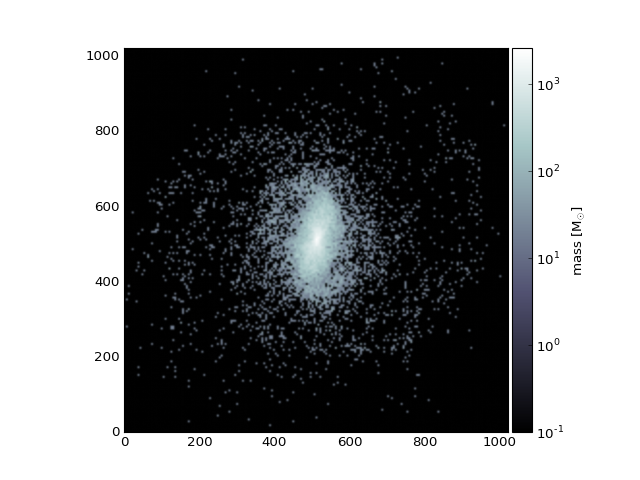

In [8]:
fig, ax = plt.subplots()
length = 1700
SF,edges = face_on_st(m_ab_B,[-length,length],200)#H.T 
SF = SF.T
mass_2 = ax.imshow(SF+0.0014,interpolation='gaussian', origin='low',cmap="bone",
                   extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=0.1,vmax=SF.max())
                  )

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')

In [9]:
SF.shape

(199, 199)

In [12]:
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

In [195]:
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

image_file = get_pkg_data_filename('/home/arturo/works/skymaker/myskys/Mochima/HR/faceR.fits')

In [196]:
fits.info(image_file)

Filename: /home/arturo/works/skymaker/myskys/Mochima/HR/faceR.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      59   (1024, 1024)   float32   


In [197]:
image_data = fits.getdata(image_file, ext=0)

<IPython.core.display.Javascript object>


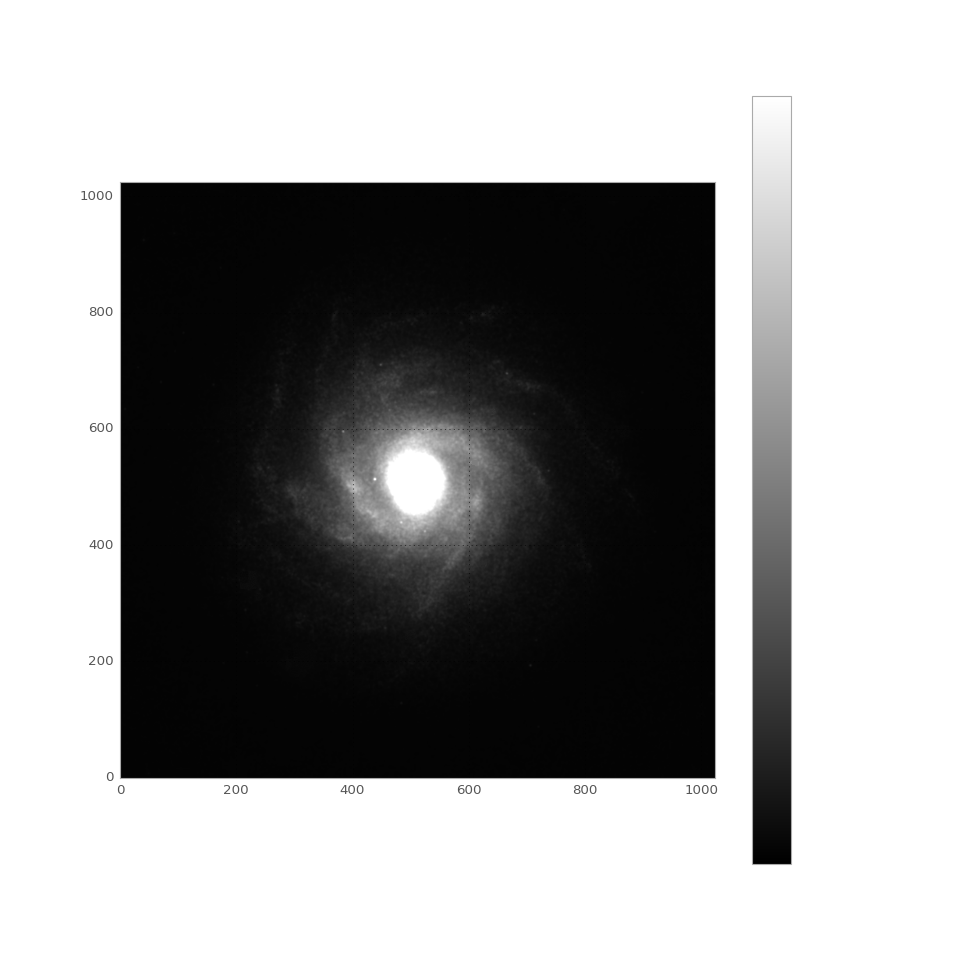

In [648]:
plt.figure(figsize=[12,12])
plt.xlim([0,1024])
plt.ylim([0,1024])

plt.imshow(image_data, cmap='gray',norm=LogNorm(vmin=3.0e3,vmax=4.1e3))
plt.colorbar()
\

3478.5007


<IPython.core.display.Javascript object>


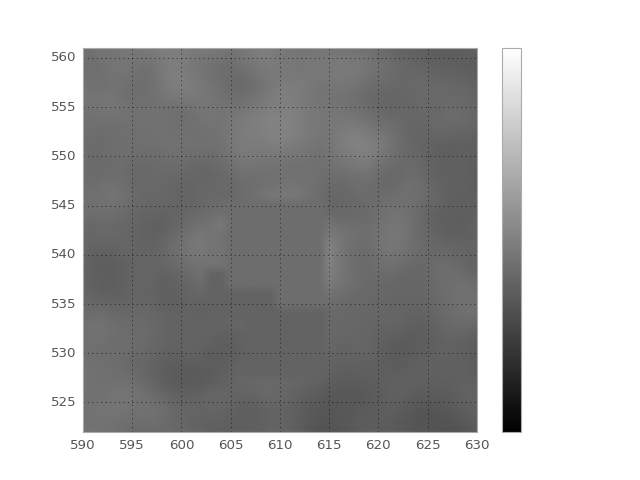

In [647]:
a,b = 537, 546 ## y
c,d = 605, 615 ## x

if np.abs(a-b)>55:
    print "nope in y"
elif np.abs(c-d)>35:
    print "nope in x"
else:
    print np.mean(image_data[a-1][c-1:d+1])
    for i in range(a,b):
        bottom ,top= c,d
        diff = top-bottom
        image_data[i][bottom:top]=np.random.rand(diff)*2.5+3500
        

plt.figure()

plt.ylim([a-15,b+15])
plt.xlim([c-15,d+15]) 

plt.imshow(image_data, cmap='gray',norm=LogNorm(vmin=3e3,vmax=4.3e3))
plt.colorbar()

In [649]:
hdu = fits.PrimaryHDU()
hdu.data = image_data
men = os.system("rm -f /home/arturo/works/skymaker/myskys/Mochima/HR/faceR_modified.fits")
print men
hdu.writeto("/home/arturo/works/skymaker/myskys/Mochima/HR/faceR_modified.fits")

0
